# Exercise 1

We will sample $10^5$ halo masses from the given distribution $dn/d\ln M$. More specifically we want to draw samples from the target pdf $p(M) = dn/dM = (dn/d\ln M)*M$, which we can easily construct. We will use rejection sampling for this purpose using a proposal pdf $q(M)$.

## Question a

In [1]:
### preliminaries

import numpy as np
from numpy import random as rnd
from scipy.interpolate import UnivariateSpline
from scipy import integrate
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from code.plot_utils import plot_pretty
plot_pretty()

In [2]:
### setting up the cosmology --- from Colossus package

from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = False

# constants and normalization constants
h = 0.7
Mpc = 3.0857e+16
Msun = 1.99e+30; Mnorm = Msun/h
dndMnorm = h**3./Mpc**3.

In [3]:
### creating the model pdf --- normalized dn/dM = M*(dn/dlnM)

def hmf_smt(lMmin, lMmax, z, cosmo):
    """
    halo mass function in the approximation of Sheth, Mo & Tormen (2001)
    
    Parameters: 
    ------------
    lMmin, lMmax - floats
        log10 of minimal and maximum halo masses (where halo mass is in /h Msun)
    z - float
        redshift for which to compute halo mass function
    cosmo - python object
        colossus cosmology object
    Returns:
    ----------
    mh - numpy array
        halo masses in /h Msun
    nsmt - numpy array
        dn/d(ln M) in (h^3 Mpc^-3)
    """
    z0 = 0.
    # grid of halo masses in /h Msun
    lmh = np.arange(lMmin, lMmax, 0.05)
    mh = np.power(10.,lmh)
    # compute Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
    rh = cosmo.lagrangianR(mh)
    # compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
    sig = cosmo.sigma(rh, z0)
    # and its logarithmic derivative dlog(sigma)/dlogR
    dsdr = cosmo.sigma(rh, z0, derivative='True')
    # dln(sigma)/dlnR -> dln(sigma)/dlnM, M = (4*pi/3) rho_mean * R^3
    dsdm = dsdr / 3.0
    #  SMT01 mass function parameters
    q_smt = 0.3; A_smt = 0.322; a_smt = 0.707
    nu = cosmo.peakHeight(mh, z)
    nup = np.sqrt(a_smt)*nu
    dsdmz = dsdm * cosmo.growthFactor(z)
    # compute dn/dlnM =M*dn/dM in (h^3 Mpc^-3) using SMT01 approximation
    nsmt = A_smt * np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh * \
            (1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)

    return mh, nsmt

m1 = 10.**11.59; norm = 2.*0.0351; beta=1.376; gamma=0.608
def ms_mh(mh):
    """
    z=0 M*-Mh relation indicated by observations from Moster et al. (2013)
    
    Parameters:
    -----------
    mh - halo mass in Msun
    """
    mu = mh/m1
    ms = mh * norm /(1./mu**beta + mu**gamma)
    return ms

In [4]:
from scipy import integrate
def log_int(func, xmin, xmax, *args):
    """
    Integration of a function in log scale using Romberg method
    Applying a variable change u = log(x)
    
    Parameters: 
    ------------
    func
        function to integrate
    xmin, xmax
        integration limits
    Returns:
    ----------
    result of integration
    """
    lfunc = lambda x: func(10.**x) * 10.**x * np.log(10)
    lxmin, lxmax = np.log10(xmin), np.log10(xmax)
    return integrate.romberg(lfunc, lxmin, lxmax)

def plot_pdf(xtarget, ytarget, sample, nbins):
    """
    Plot of the sampled distribution with the target pdf for comparison 
    (the proposal pdf is also plotted)
    
    Input: 
    ------------
    sampled - numpy array, float
        samples from target distribution
        
    xterget - numpy array, floats
        masses of the halos
        
    ytarget - numpy array, float
        target distribution
    Returns:
    ----------
    The plots in one figure
    """
    plt.figure(figsize=(4.,4.))
    
    # plot of target pdf
    plt.plot(xtarget, ytarget, c='darkslateblue')
    
    # proposal pdf
    plt.plot(Mhalo, q(Mhalo), 'k--')
   
    # histogram of selected samples
    bins=np.logspace(lMmin,lMmax,nbins)
    plt.hist(sample, normed=True, bins=bins, histtype='step',\
             stacked=True, fill=False, color = 'crimson', linewidth=1.2)
    
    # axis and scale (we use log-log scaling)
    plt.xlabel(r'$M\ (M_{\odot})$'); #plt.ylabel(r'')
    plt.xscale('log'); plt.yscale('log')
    
    plt.legend(('target pdf - p(x)', 'proposal pdf - q(x)','rejection sampling'),\
               fontsize=9, loc='best', frameon='False')
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}
    
    plt.rc('font', **font)
    
    plt.show()

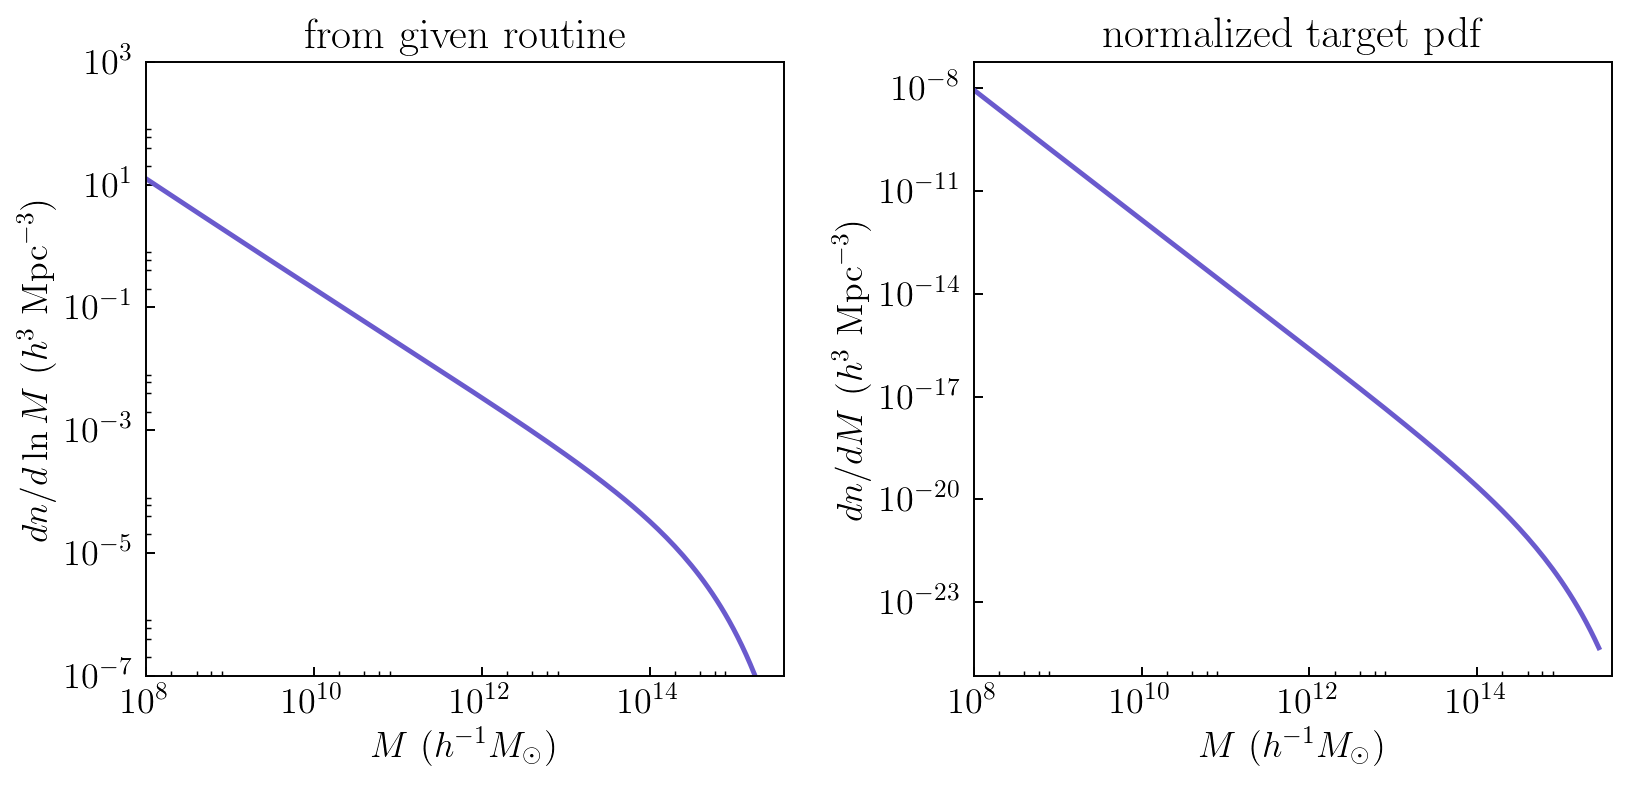

In [6]:
"""
    Plot of dn/dlnM and dn/dM=(dn/dlnM)/M
"""
# parameters
lMmin, lMmax = 8., 15.5
Mmin, Mmax = 10**lMmin, 10**lMmax # minimum and maximum masses
z = 0. # redshift

# target pdf construction
Mhalo, dndlnM = hmf_smt(lMmin, lMmax, z, cosmo) # dn/dlnM
lMhalo = np.log10(Mhalo)

# dn/dM = (dn/dlnM)/M
dndM = dndlnM / Mhalo

# splines interpolation of dn/dM
from scipy.interpolate import UnivariateSpline
dndMspl = UnivariateSpline(Mhalo, dndM, s=0.)

# normalization of target pdf
from scipy import integrate
dndMnorm = log_int(dndMspl, Mmin, Mmax)
dndM /= dndMnorm
dndMspl = UnivariateSpline(Mhalo, dndM, s=0.)

# plots
fig, ax = plt.subplots(1,2,figsize=(9.,4.))
fig.tight_layout(pad=0.4, w_pad=3.0, h_pad=1.0)

ax[0].plot(Mhalo, dndlnM, c='slateblue', linewidth=2.0, label=r'$z=%.1f$'%z)
ax[0].set_xlabel(r'$M\ (h^{-1} M_{\odot})$'); ax[0].set_ylabel(r'$dn/d\ln M\ (h^3\ \rm Mpc^{-3})$')
ax[0].set_yscale('log'); ax[0].set_xscale('log')
ax[0].set_xlim(1.e8, 4.e15); ax[0].set_ylim(1.e-7,1.e3)
ax[0].set_title('from given routine')

ax[1].plot(Mhalo, dndM, c='slateblue', linewidth=2.0, label=r'$z=%.1f$'%z)
ax[1].set_xlabel(r'$M\ (h^{-1} M_{\odot})$'); ax[1].set_ylabel(r'$dn/dM\ (h^3\ \rm Mpc^{-3})$')
ax[1].set_yscale('log'); ax[1].set_xscale('log')
ax[1].set_xlim(1.e8, 4.e15); #ax[1].set_ylim(1.e-7,1.e3)
ax[1].set_title('normalized target pdf')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
    
#plt.legend(frameon=False, loc='lower left', fontsize=20)
#plt.grid()
plt.show()

In [7]:
def rej_sample(pdf, prop_pdf, x, sample_size):
    """
    Implementation of rejection sampling
    
    Input: 
    ------------
    pdf         - function
        the target pdf
        
    prop_pdf    - function
        proposal pdf
        
    x           - numpy array, floats
        the x values
        
    sample_size - int
        number of points to sample
        
    Returns:
    ----------
    The sampled points from pdf and the acceptance probability
    """
    
    Ntot = 0  # counting trials
    Nacc = 0  # counting accepted masses
    m = 1.    # constant in q(x) > m*p(x) condition
    
    yacc = np.zeros(sample_size) # accepted samples array
    
    # cdf of proposal pdf
    #---------------------------------------
    qcdf = np.zeros(len(x))
    for i in range(len(x)):
        qcdf[i] = log_int(prop_pdf, x[0], x[i])
    qcdf /= qcdf.max()
    
    # inverse of cdf
    invqcdf = UnivariateSpline(qcdf, x, s=0.)
    #---------------------------------------

    while Nacc < sample_size:
    
        # draw from proposal pdf
        urnd = rnd.uniform(0., 1.); xq = invqcdf(urnd)
    
        # pdf, p(x), and proposal pdf, q(x), at xq
        prnd = pdf(xq); qrnd = q(xq)
        
        # draw a uniform random number between 0 and 1
        u = rnd.uniform(0., 1.)
    
        # check if random number will be accepted
        if u < prnd/(m*qrnd):
            yacc[Nacc] = xq
            Nacc += 1
    
        Ntot += 1
        
        # acceptiance probavility
        pacc = 1.*sample_size/Ntot

    return yacc, pacc, Ntot

In [8]:
"""
    Using the target pdf p(x) derived from routine "hmf_smt", we want to sample 10^5 halos 
    with masses inside the interval [Mmin,Mmax].
    We implement a rejection sampling routine with a proposed distribution q(x) for which 
    q(x) > m*p(x) for all x, where m is a constant.
"""
from numpy import random as rnd

# proposal pdf
q = lambda x: 10.**9./x**2.

# run rejection sampler
# to draw Nhalo=10^5 sample masses
Nhalo = 100000

from time import time
# run sampler
tstart = time()
yacc, acc_prob, Ntry = rej_sample(dndMspl, q, Mhalo, Nhalo)

print("sampling finished in %.3f s"%(time()-tstart))
print("selected %d samples after trying %d times"%(np.size(yacc), Ntry))
print("acceptance probability is %.3e"%(acc_prob))

sampling finished in 15.443 s
selected 100000 samples after trying 992546 times
acceptance probability is 1.008e-01


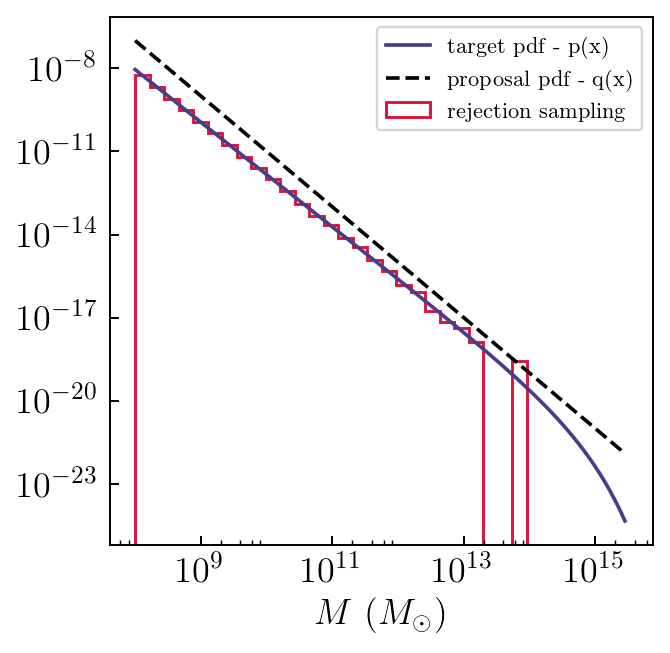

In [9]:
# plot target pdf, proposal pdf, and sampling histogram
nbins = 35
plot_pdf(Mhalo, dndM, yacc, nbins)

### Comments

* Large values for M do not get sampled very well, probably due to the condition u < prnd/(m*qrnd) in the code for rejection sampling. Since we draw random uniform numbers from the proposal pdf, namely qrnd, due to the fact that the minimim and maximum values of q differ by $\sim 15$ orders of magnitude and because the minimum value of q is very small, it is more probable to draw uniform random numbers close to smaller masses, and thus we see the above picture.

* If we change how much higher the proposal pdf is than the target pdf, the acceptance efficiency goes down and the routine takes much more time to finish sampling. For instance, below we increase the distance between them by a factor of $10$ and the time it takes the routine to finish increased by an order of $\sim 10$; the acceptance probability dropped by a factor of $\sim 10$.

In [10]:
# proposal pdf
q = lambda x: 10.**10./x**2.

Nhalo = 100000
tstart = time()
yacc, acc_prob, Ntry = rej_sample(dndMspl, q, Mhalo, Nhalo)

print("sampling finished in %.3f s"%(time()-tstart))
print("selected %d samples after trying %d times"%(np.size(yacc), Ntry))
print("acceptance probability is %.3e"%(acc_prob))

sampling finished in 157.191 s
selected 100000 samples after trying 10022308 times
acceptance probability is 9.978e-03


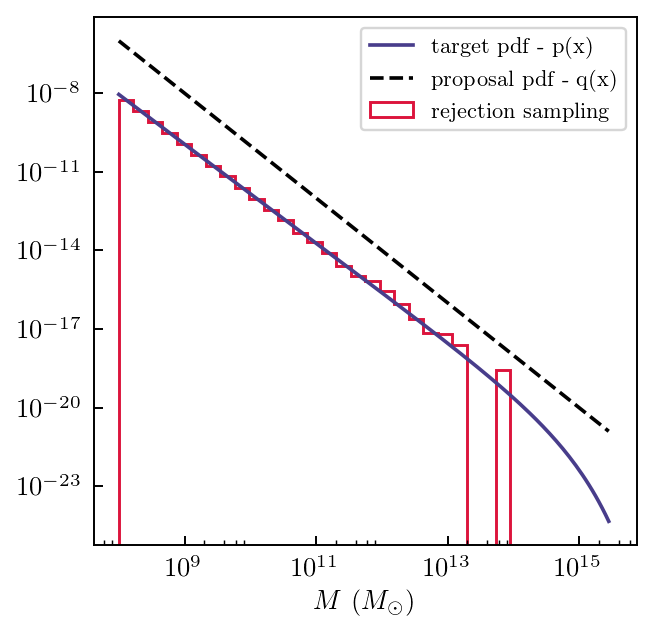

In [11]:
# plot target pdf, proposal pdf, and sampling histogram
nbins = 35
plot_pdf(Mhalo, dndM, yacc, nbins)

## Question b

Now we want to assign stellar mass, $M_{\star}$, to each of the $10^5$ halo masses, $M$, drawing values from the distribution
$$
p(M_\star\vert M) = \frac{1}{\sqrt{2\pi}s_\star}\,\exp\left[-\frac{(\log_{10}M_\star -\langle \log_{10}M_\star\rangle)^2}{2s_\star^2}\right],
$$
where the mean $\langle \log_{10} M_\star \rangle$ as a function of $\log_{10} M$ is given by the routine ms_mh.

In [12]:
""" Assign star masses to each of our sampled halo masses from above """

# sort the halo masses
smhalo = np.sort(yacc)

# initialize star-mass list
Mstar = []

# s_star=0.16 as indicated
s = 0.16

for i in range(Nhalo):
    # mean for each halo mass from ms_mh
    mean = ms_mh(smhalo[i]/cosmo.h)
    lmean = np.log10(mean)
    # draw a random normal number with mean <log10(M_star)> and sigma-s_star
    lx = rnd.normal(lmean, s, 1)
    # save star mass
    Mstar.append(10**lx)

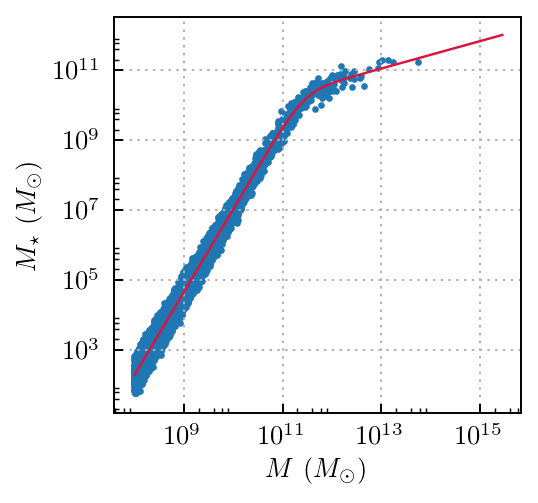

In [13]:
"""Plot of assigned star masses and the mean M-Mstar relation"""

ms = ms_mh(Mhalo/cosmo.h)

# plot halo mass function
fig = plt.figure(figsize = (3,3))
plt.xlabel(r'$M\  (M_{\odot})$'); plt.ylabel(r'$M_\star\ (M_\odot)$')
plt.yscale('log'); plt.xscale('log')

plt.plot(Mhalo, ms, c='crimson', linewidth=1.0) 
plt.scatter(smhalo, Mstar, s=3) 

plt.grid(ls='dotted')
plt.show()

### Exercise 2

In [14]:
from matplotlib.colors import LogNorm

def plot_2d(x1, x2, nbins, x_size, y_size, font_size):
    """Routine for plotting 2d histograms"""
    plt.figure(figsize=(x_size,y_size))
    
    plt.hist2d(x1, x2, bins=nbins, norm=LogNorm())
    plt.colorbar()
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : font_size}

    plt.rc('font', **font)
    
    plt.show()

In [15]:
""" Required functions"""

def gaussian2d(xin, args):
    """2d Gaussian with non-zero correlation coefficient r
    vectorized version of the function"""
    x = xin[0]; y = xin[1]
    sig1 = args[0]; sig2 = args[1]; r = args[2]; r2 = r*r
    lres = -0.5*((x/sig1)**2+(y/sig2)**2-2.0*r*x*y/(sig1*sig2))/(1.0-r2) - (2*np.pi*sig1*sig2) - np.sqrt(1.0-r2)
    return np.exp(lres)

def gaussian2d_vec(x, args):
    """2d Gaussian with non-zero correlation coefficient r
    vectorized version of the function"""
    
    sig1 = args[0]; sig2 = args[1]; r = args[2]
    r2 = r*r
    res = -0.5*((x[:,0]/sig1)**2+(x[:,1]/sig2)**2-2.0*r*x[:,0]*x[:,1]/(sig1*sig2))/(1.0-r2)\
    - (2*np.pi*sig1*sig2) - np.sqrt(1.0-r2)
    return res

#fa1 = 0.1; fx1 =  4.0; fy1 =  80.0; fsx1 = 0.1; fsy1 = .2; fr1 = -.7
#fa2 = 0.1; fx2 =  -4.0; fy2 =  80.0; fsx2 = 0.1; fsy2 = .2; fr2 = .8
def smiley_face(xin, arg):
    x = xin[0]; y = xin[1]
    fa1, fr1, fx1, fsx1, fy1, fsy1 = arg[0]
    fa2, fr2, fx2, fsx2, fy2, fsy2 = arg[1]
    # Gaussian pdfs 1 and 2
    res  = fa1*np.exp(-0.5/(1 - fr1**2)*( ((x-fx1)/fsx1)**2 + ((y-fy1)/fsy1)**2 + 2*fr1*(x-fx1)*(y-fy1)/(fsx1*fsy1) )) 
    res += fa2*np.exp(-0.5/(1 - fr2**2)*( ((x-fx2)/fsx2)**2 + ((y-fy2)/fsy2)**2 + 2*fr2*(x-fx2)*(y-fy2)/(fsx2*fsy2) ))
    # + Rosenbrock pdf
    res += np.exp(-(100.*(y-x**2)**2 + (4.0-x)**2)/20.0)
    return res

def smiley_face_vec(xin, arg):
    x = xin[:,0]; y = xin[:,1]
    fa1, fr1, fx1, fsx1, fy1, fsy1 = arg[0]
    fa2, fr2, fx2, fsx2, fy2, fsy2 = arg[1]
    # Gaussian pdfs 1 and 2
    res  = fa1*np.exp(-0.5/(1 - fr1**2)*( ((x-fx1)/fsx1)**2 + ((y-fy1)/fsy1)**2 + 2*fr1*(x-fx1)*(y-fy1)/(fsx1*fsy1) )) 
    res += fa2*np.exp(-0.5/(1 - fr2**2)*( ((x-fx2)/fsx2)**2 + ((y-fy2)/fsy2)**2 + 2*fr2*(x-fx2)*(y-fy2)/(fsx2*fsy2) ))
    # + Rosenbrock pdf
    res += np.exp(-(100.*(y-x**2)**2 + (4.0-x)**2)/20.0)
    return np.log(res)

In [16]:
def init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """Distribute initial positions of walkers in an isotropic Gaussian around the initial point"""
    np.random.seed()
    
    # the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x

def mcmc_init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """
    distribute initial positions of walkers in an isotropic Gaussian around the initial point
    (for vectorized of mcmc provided)
    """
    np.random.seed()
    
    # in this implementation the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x

In [17]:
def vectorized_mcmc2(x, nparams=2, nsteps = 10000, step=None, nwalkers=100, nRval=10, Rconv=1.01, modelpdf = None, 
                     ipar_active = None, params=[]):
    """
    MCMC sampler implementing a simple Metropolis algorithm
    inner loop is vectorized
    
    """
    
    #try:
    #    import acor
    #except:
    #    raise Exception("acor package is not installed!")
        
    # calculate effective number of parameters if some are specified to be fixed
    ia = (ipar_active==1)
    npareff = np.size(ipar_active[ia])
    print("starting sampling with %d active parameters of the total %d parameters"%(npareff, nparams))
    
    # initialize some auxiliary arrays and variables 
    chain = []; Rval = []

    naccept = 0; ntry = 0; nchain = 0
    mw = np.zeros((nwalkers,npareff)); sw = np.zeros((nwalkers,npareff))
    m = np.zeros(npareff); Wgr = np.zeros(npareff); Bgr = np.zeros(npareff); Rgr = np.zeros(npareff)
    
    mutx = []; taux = []
    for i in range(npareff): 
        mutx.append([]); taux.append([])
        Rval.append([])

    gxo = np.zeros((2,nwalkers/2))
    gxo[0,:] = modelpdf(x[0,:,:], params); gxo[1,:] = modelpdf(x[1,:,:], params)
    converged = False;

    while nchain*nwalkers < nsteps:
        # for parallelization 
        # the walkers are split into two complementary sub-groups (a la algorithm 3 of Foreman-Mackey+)
        for kd in range(2):
            k = abs(kd-1)
            # vectorized inner loop of walkers stretch move in the  sampling algorithm
            xchunk = x[k,:,:]; gxold  = gxo[k,:]
            xtry  = xchunk + step*np.random.uniform(-1.0,1.0,np.shape(xchunk))   
            gxtry = modelpdf(xtry, params); gx = np.copy(gxold) 
            gr   = gxtry - gx
            iacc = np.where(gr>0.)
            xchunk[iacc] = xtry[iacc]
            gxold[iacc] = gxtry[iacc]
            naccept += len(iacc[0])
            aprob = gxtry - gx
            u = np.random.uniform(0.0,1.0,np.shape(xchunk)[0])        
            iprob = np.where(aprob > np.log(u))
            xchunk[iprob] = xtry[iprob]
            gxold[iprob] = gxtry[iprob]
            naccept += len(iprob[0])

            x[k,:,ia] = np.transpose(xchunk[:,ia])
            gxo[k,:] = gxold        
            xdum = x[:,:,ia]

            for i in range(nwalkers/2):
                chain.append(np.array(xdum[k,i,:]))

            for i in range(nwalkers/2):
                mw[k*nwalkers/2+i,:] += xdum[k,i,:]
                sw[k*nwalkers/2+i,:] += xdum[k,i,:]**2
                ntry += 1

        nchain += 1
        
        # compute means for the auto-correlation time estimate
        for i in range(npareff):
            mutx[i].append(np.sum(xdum[:,:,i])/(nwalkers))

        # compute Gelman-Rubin indicator for all parameters
        if ( nchain >= nwalkers/2 and nchain%nRval == 0):
            # calculate Gelman & Rubin convergence indicator
            mwc = mw/(nchain-1.0)
            swc = sw/(nchain-1.0)-np.power(mwc,2)

            for i in range(npareff):
                # within chain variance
                Wgr[i] = np.sum(swc[:,i])/nwalkers
                # mean of the means over Nwalkers
                m[i] = np.sum(mwc[:,i])/nwalkers
                # between chain variance
                Bgr[i] = nchain*np.sum(np.power(mwc[:,i]-m[i],2))/(nwalkers-1.0)
                # Gelman-Rubin R factor
                Rgr[i] = (1.0 - 1.0/nchain + Bgr[i]/Wgr[i]/nchain)*(nwalkers+1.0)/nwalkers - (nchain-1.0)/(nchain*nwalkers)
                #tacorx = acor.acor(mutx[i])[0]; taux[i].append(np.max(tacorx))
                Rval[i].append(Rgr[i]-1.0)
            if np.max(np.abs(Rgr)) < Rconv: converged = True
        
    print("MCMC sampler generated %d samples using %d walkers"%(ntry, nwalkers))
    print("with step acceptance ratio of %.3e"%(1.0*naccept/ntry))
        
    # record integer auto-correlation time at the final iteration
    #nthin = int(tacorx)

    return chain, Rval#, nthin

In [18]:
def affine_mcmc(nsteps, nwalkers, modelpdf, *args):
    """
    Affine MCMC routine. Implements the Algorithm 3 in Foreman-Mackey et al (2010)
    which is equivalent to the Goodman & Weare (2010) method, but easily vectorizable.
    1) We first initialize the walkers with a specific distribution. This returns two 
       groups of walkers.
    2) Then, for each group, we select a random walker Xk and update its position 
       using the position of a walker Sk in the other group
    3) We place Xk in Sk's position
    4) Then, we draw a random number Z from g(z) = {1/sqrt(z), if z in [1/2,2] || 0, otherwise }
    5) Then, for every walker Xj in the group, generate Y = Xj + Z*(Xk - Xj).
    6) Also, generate number q=z^(2-1)*p(Y)/p(Xk), where p(x) is the target pdf we want to sample
    7) Choose a unifrom random number
    8) Accept Y as the next position in chain if r<=q, or if r>q use Xk as the next starting position
    9) Repeat for all walkers in other group
    
    Parameters:
    ------------
    n        - integer
        number of MCMC steps (iterations) to take
    nwalkers - integer
        number of walkers
    x0       - array, float
        initial x value
    step     - float
        step size controlling step proposal distribution
    modelpdf - python function object
        ln(pdf) where pdf is the target pdf to sample
    args     - pointer to a list
        list of arguments to pass modelpdf
        
    Returns:
    ---------
    xchain - list
        list of x values in the MCMC chains
    pacc   - float
        acceptance ratio of the MCMC steps (ratio of accepted to the total proposed number of steps)
    """
    
    # initialize walkers according to initialization routine
    #---------------------------------------------------------------------------------------------
    # initialization parameters
    x0 = np.array([0., 0.]); step = np.array([0.1,0.1])

    # if entry is set to 0, the corresponding parameter is not sampled, but kept at the initial value
    ipar_active = np.array([1, 1])

    # run initialization routine to get initial values for positions of walkers
    # Note: this creates nparams groups of walkers, x0[0,:,:], ..., x0[nparams,:,:]
    x0 = init(nparams=2, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)
    #-----------------------------------------------------------------------------------------------
    
    # cdf of pdf g(z) for sampling (inverse sampling)
    #--------------------------------------------------------------------
    # function g(z) = {1/sqrt(z), if 1/a<z<a | 0, otherwise}
    a = 2. # a=2, as suggested in literature
    
    gnorm = 2*(np.sqrt(a) - 1/np.sqrt(a)) # normalization factor for g(z)
    g = lambda z: (1./np.sqrt(z)) / gnorm # normalizaed g(z)

    # cdf of g(z)
    g_range = np.linspace(1./a, a, 1000)
    gcdf = np.zeros(len(g_range))
    
    for i in range(len(g_range)):
        gcdf[i] = integrate.romberg(g, g_range[0], g_range[i])
    
    # inverse of cdf of g(z)
    ginvcdf = UnivariateSpline(gcdf, g_range, s=0.)
    #--------------------------------------------------------------------
    
    x = x0         # initialization of walkers
    group = [0,1]  # the two groups of walkers
    niter = 0      # number of iterations
    chain = []     # chain of walkers
    
    while niter < nsteps:
        for i in range(len(group)):
            for k in range(len(x[i,:,0])):
                
                # select walker xk from current group
                xk = x[i,k,:]
                
                # select walker at random from complementary group
                # ------------------------------------------------
                # get index of complementary group of walkers 
                kc = group[::-1][i]
                
                # choose random walker xj from complementary group
                j = rnd.randint(0,len(x[kc,:,0])-1,1)[0]
                xj = x[kc,j,:]
                #--------------------------------------------------

                # draw z from g(z) -- we use inverse sampling
                uz = rnd.uniform(0.,1.); z = ginvcdf(uz)
            
                # create y = xj + z*(xk-xj)
                y = xj + z*(xk - xj)
            
                # generate q = z^(D-1)*(p(y)/p(xk))
                D = 2 # number of components in x
                py = modelpdf(y, *args); pk = modelpdf(xk, *args)
                q = z**(D-1) * (py / pk)
            
                # draw a random uniform number r
                r = rnd.uniform(0.,1.)
            
                #
                # check if y will be accepted
                #
                if r <= q:
                    # if yes, then append y to chain and 
                    # update walker's position using xk=y
                    chain.append(np.array(y))
                    x[i,k,:] = y
                else:
                    # else, append xk to the chain and
                    # keep xk as the walker's next position
                    chain.append(np.array(xk))
                    
        niter += 1
    
    print("sampling finished")
    return chain

In [63]:
"""2D Gaussian with affine mcmc"""

# number of walkers
nwalkers = 1000

# number of steps for walkers
nsteps = 10000

# arguments for gaussian: sigma_1, sigma_2, r
arg = [5,6,0.9]

from time import time
# run sampler
tstart = time()
xgauss = affine_mcmc(nsteps, nwalkers, gaussian2d, arg)
print("sampled in %.3f sec"%(time()-tstart))

# organise results
x1gauss = zip(*xgauss)[0]; x2gauss = zip(*xgauss)[1]

sampling finished
sampled in 227.390 sec


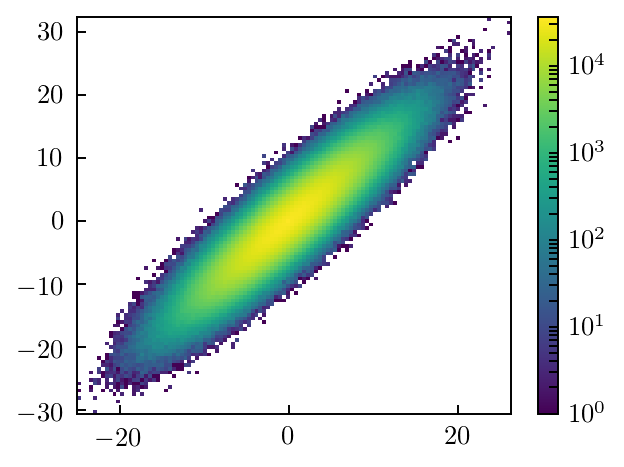

In [64]:
nbins=110; x_dim=4.; y_dim=3.; font_size = 11
plot_2d(x1gauss, x2gauss, nbins, x_dim, y_dim, font_size)

In [61]:
"""2D Gaussian with vectorized mcmc"""

# number of walkers
nwalkers = 20

# number of steps for walkers
nsteps = 500000

# initialization parameters
x0 = np.array([0., 0.]); step = np.array([0.1,0.1])

# if entry is set to 0, the corresponding parameter is not sampled, but kept at the initial value
ipar_active = np.array([1, 1])

# run initialization routine to get initial values for positions of walkers
# Note: this creates nparams groups of walkers, x0[0,:,:], ..., x0[nparams,:,:]
x0 = init(nparams=2, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)
#-----------------------------------------------------------------------------------------------

from time import time
# run sampler
arg = [5,6,0.9]
tstart = time()
xchain, Rval = vectorized_mcmc2(x0, nparams=2, nsteps = nsteps, step = 1., nwalkers=nwalkers, modelpdf = gaussian2d_vec, 
                                ipar_active = ipar_active, params=arg,  Rconv = 1.01 )

print("sampled in %.3f sec"%(time()-tstart))

# organize results
x1 = zip(*xchain)[0]; x2 = zip(*xchain)[1] 

starting sampling with 2 active parameters of the total 2 parameters
MCMC sampler generated 500000 samples using 20 walkers
with step acceptance ratio of 1.323e+00
sampled in 4.192 sec


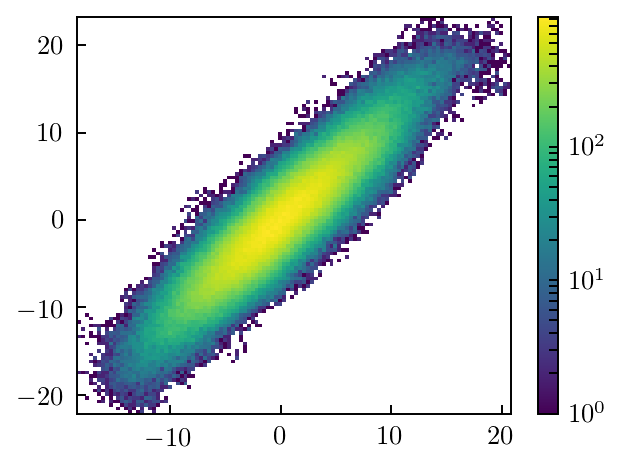

In [65]:
nbins=110; x_dim=4.; y_dim=3.; font_size = 11
plot_2d(x1, x2, nbins, x_dim, y_dim, font_size)

In [67]:
"""Smiley face with affine mcmc"""

# number of walkers
nwalkers = 1000

# number of steps for walkers
nsteps = 10000

# arguments for smiley face
fa1 = 0.1; fx1 =  1.0; fy1 =  8.0; fsx1 = 0.1; fsy1 = .2; fr1 = -.7
fa2 = 0.1; fx2 =  -1.0; fy2 =  8.0; fsx2 = 0.1; fsy2 = .2; fr2 = .8

arg1 = np.array([fa1, fr1, fx1, fsx1, fy1, fsy1])
arg2 = np.array([fa2, fr2, fx2, fsx2, fy2, fsy2])

arg = np.array([arg1, arg2])

from time import time
# run sampler
tstart = time()
xaffsmiley = affine_mcmc(nsteps, nwalkers, smiley_face, arg)
print("sampled in %.3f sec"%(time()-tstart))

# organise results
xaff1smiley = zip(*xaffsmiley)[0]; xaff2smiley = zip(*xaffsmiley)[1]

sampling finished
sampled in 368.264 sec


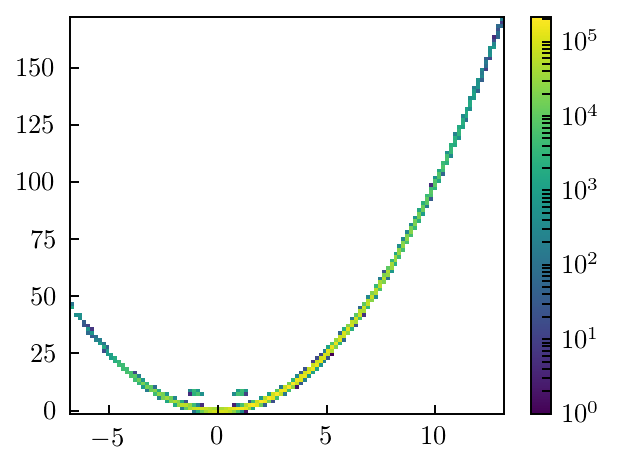

In [68]:
nbins=110; x_dim=4.; y_dim=3.; font_size = 11
plot_2d(xaff1smiley, xaff2smiley, nbins, x_dim, y_dim, font_size)

In [74]:
"""Smiley face with vectorized mcmc"""

# number of walkers
nwalkers = 20

# number of steps for walkers
nsteps = 500000

# initialization parameters
x0 = np.array([0., 0.]); step = np.array([0.1,0.1])

# if entry is set to 0, the corresponding parameter is not sampled, but kept at the initial value
ipar_active = np.array([1, 1])

# run initialization routine to get initial values for positions of walkers
# Note: this creates nparams groups of walkers, x0[0,:,:], ..., x0[nparams,:,:]
x0 = init(nparams=2, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)
#-----------------------------------------------------------------------------------------------

# arguments for smiley face
fa1 = 0.1; fx1 =  1.0; fy1 =  8.0; fsx1 = 0.1; fsy1 = .2; fr1 = -.7
fa2 = 0.1; fx2 =  -1.0; fy2 =  8.0; fsx2 = 0.1; fsy2 = .2; fr2 = .8

arg1 = np.array([fa1, fr1, fx1, fsx1, fy1, fsy1])
arg2 = np.array([fa2, fr2, fx2, fsx2, fy2, fsy2])

arg = np.array([arg1, arg2])

from time import time
# run sampler
tstart = time()
xvecsmiley, Rval = vectorized_mcmc2(x0, nparams=2, nsteps = nsteps, step = 0.1, nwalkers=nwalkers, modelpdf = smiley_face_vec, 
                                ipar_active = ipar_active, params=arg,  Rconv = 1.01 )
print("sampled in %.3f sec"%(time()-tstart))

# organise results
xvec1smiley = zip(*xvecsmiley)[0]; xvec2smiley = zip(*xvecsmiley)[1]

starting sampling with 2 active parameters of the total 2 parameters
MCMC sampler generated 500000 samples using 20 walkers
with step acceptance ratio of 1.241e+00
sampled in 5.795 sec


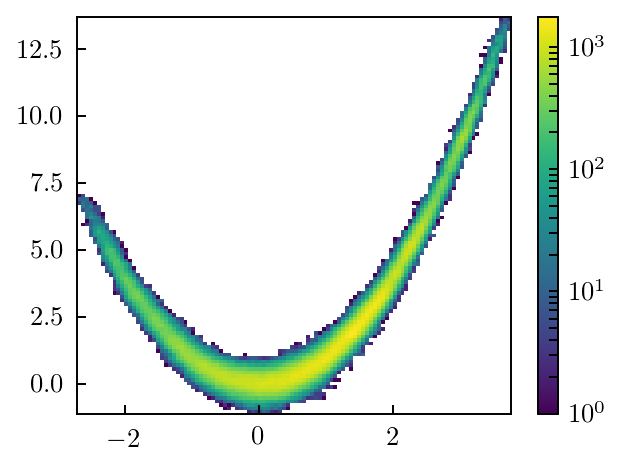

In [70]:
nbins=110; x_dim=4.; y_dim=3.; font_size = 11
plot_2d(xvec1smiley, xvec2smiley, nbins, x_dim, y_dim, font_size)

### Comments

* Our affine mcmc routine seems to pass the test of the 2D Gaussian distribution, and it is also able to sample the smiley-face pdf with the eyes showing clearly and sharply. The vectorized mcmc routine, on the other hand, is not able to discover the eyes, and also the form of the distribution it gives differs from the expected in that the final result is much more wide.



* (First question in homework) It is obvious from above that for the vectorized Metropolis routine the time required for sampling is orders of magnitude lower. Probably this is due to the vectorization of the Metropolis routine. Also, the sampling of the Gaussian seems to be almost equally good, whereas in the case of the smiley face our GW10 algorithm work much better; a possible explanation for this is given below. 



* (Second question in homework) The fact that affine mcmc algorithms work better with pdfs with narrow ridges has to do with the way they propose a step at each iteration. In our implementation, for instance, we propose a step that combines information from two walkers; specifically, the step is at the direction of the line between the two walkers. This allows the walkers to "communicate" with each other, and a walker will make a step towards the other depending on whether the latter walker is in an area of higher probability than the former. That way the walkers explore their space and are attracted quickly to areas of high probability. On the other hand, in the Metropolis algorithm the walkers explore the area with constant step in a much more random way and whether a step will be taken depends on whether this step will take them to a higher probability area. Therefore, although in both cases the walkers move around the high-probability areas, in the latter case the walkers spread to a wider area around them, and thus for distributions with narrow ridges the sampling will to be as successful as in the case where we use the GW10 algorithm, as it is obvious from the above results. Also, the eyes of the smiley face distribution are harder to be discovered by the Metropolis algorithm for the same reasons.